# import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats


# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor


# Read data

In [51]:
park_data = pd.read_csv("parkinsons.csv")

park_inp = park_data.drop("target", axis=1)
park_tar = park_data["target"]

# Basic data visualisation and scale analysis

### Target visualisation for curiosity

It's interesting to note that the scale varies from 0 to 260. Although as we will see in the target visualisation we only have scores below 

(array([ 249.,  471.,  754.,  984., 1044.,  836.,  591.,  550.,  183.,
         213.]),
 array([ 7.    , 11.7992, 16.5984, 21.3976, 26.1968, 30.996 , 35.7952,
        40.5944, 45.3936, 50.1928, 54.992 ]),
 <BarContainer object of 10 artists>)

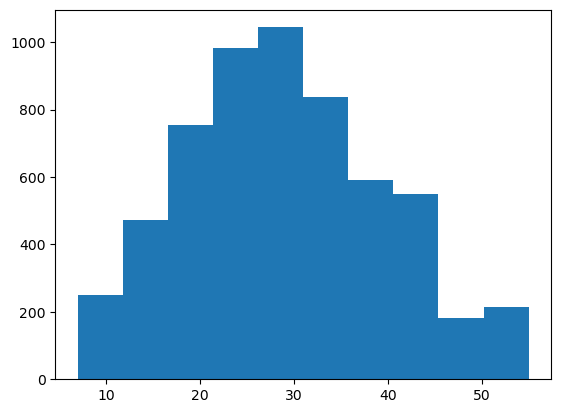

In [68]:
plt.hist(park_tar)
#plt.xlim([0,260])

Min, Max, and Difference values for each column:
                    Min        Max  Difference
age           -3.265580   2.289489    5.555069
sex           -0.682509   1.465182    2.147691
test_time     -1.817446   2.294608    4.112054
Jitter(%)     -0.946657  16.685707   17.632364
Jitter(Abs)   -1.161111  11.160633   12.321744
Jitter:RAP    -0.850693  17.464987   18.315680
Jitter:PPQ5   -0.762982  17.764476   18.527458
Jitter:DDP    -0.851770  17.465979   18.317749
Shimmer       -1.199058   9.081220   10.280278
Shimmer(dB)   -1.237697   7.800931    9.038628
Shimmer:APQ3  -1.174502  10.993835   12.168337
Shimmer:APQ5  -1.092523   8.814745    9.907268
Shimmer:APQ11 -1.250516  12.408608   13.659124
Shimmer:DDA   -1.174245  10.994080   12.168325
NHR           -0.533344  11.998215   12.531559
HNR           -4.665987   3.774533    8.440520
RPDE          -3.866744   4.204980    8.071724
DFA           -1.963436   2.995380    4.958816
PPE           -2.159850   5.597736    7.757586
target     

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

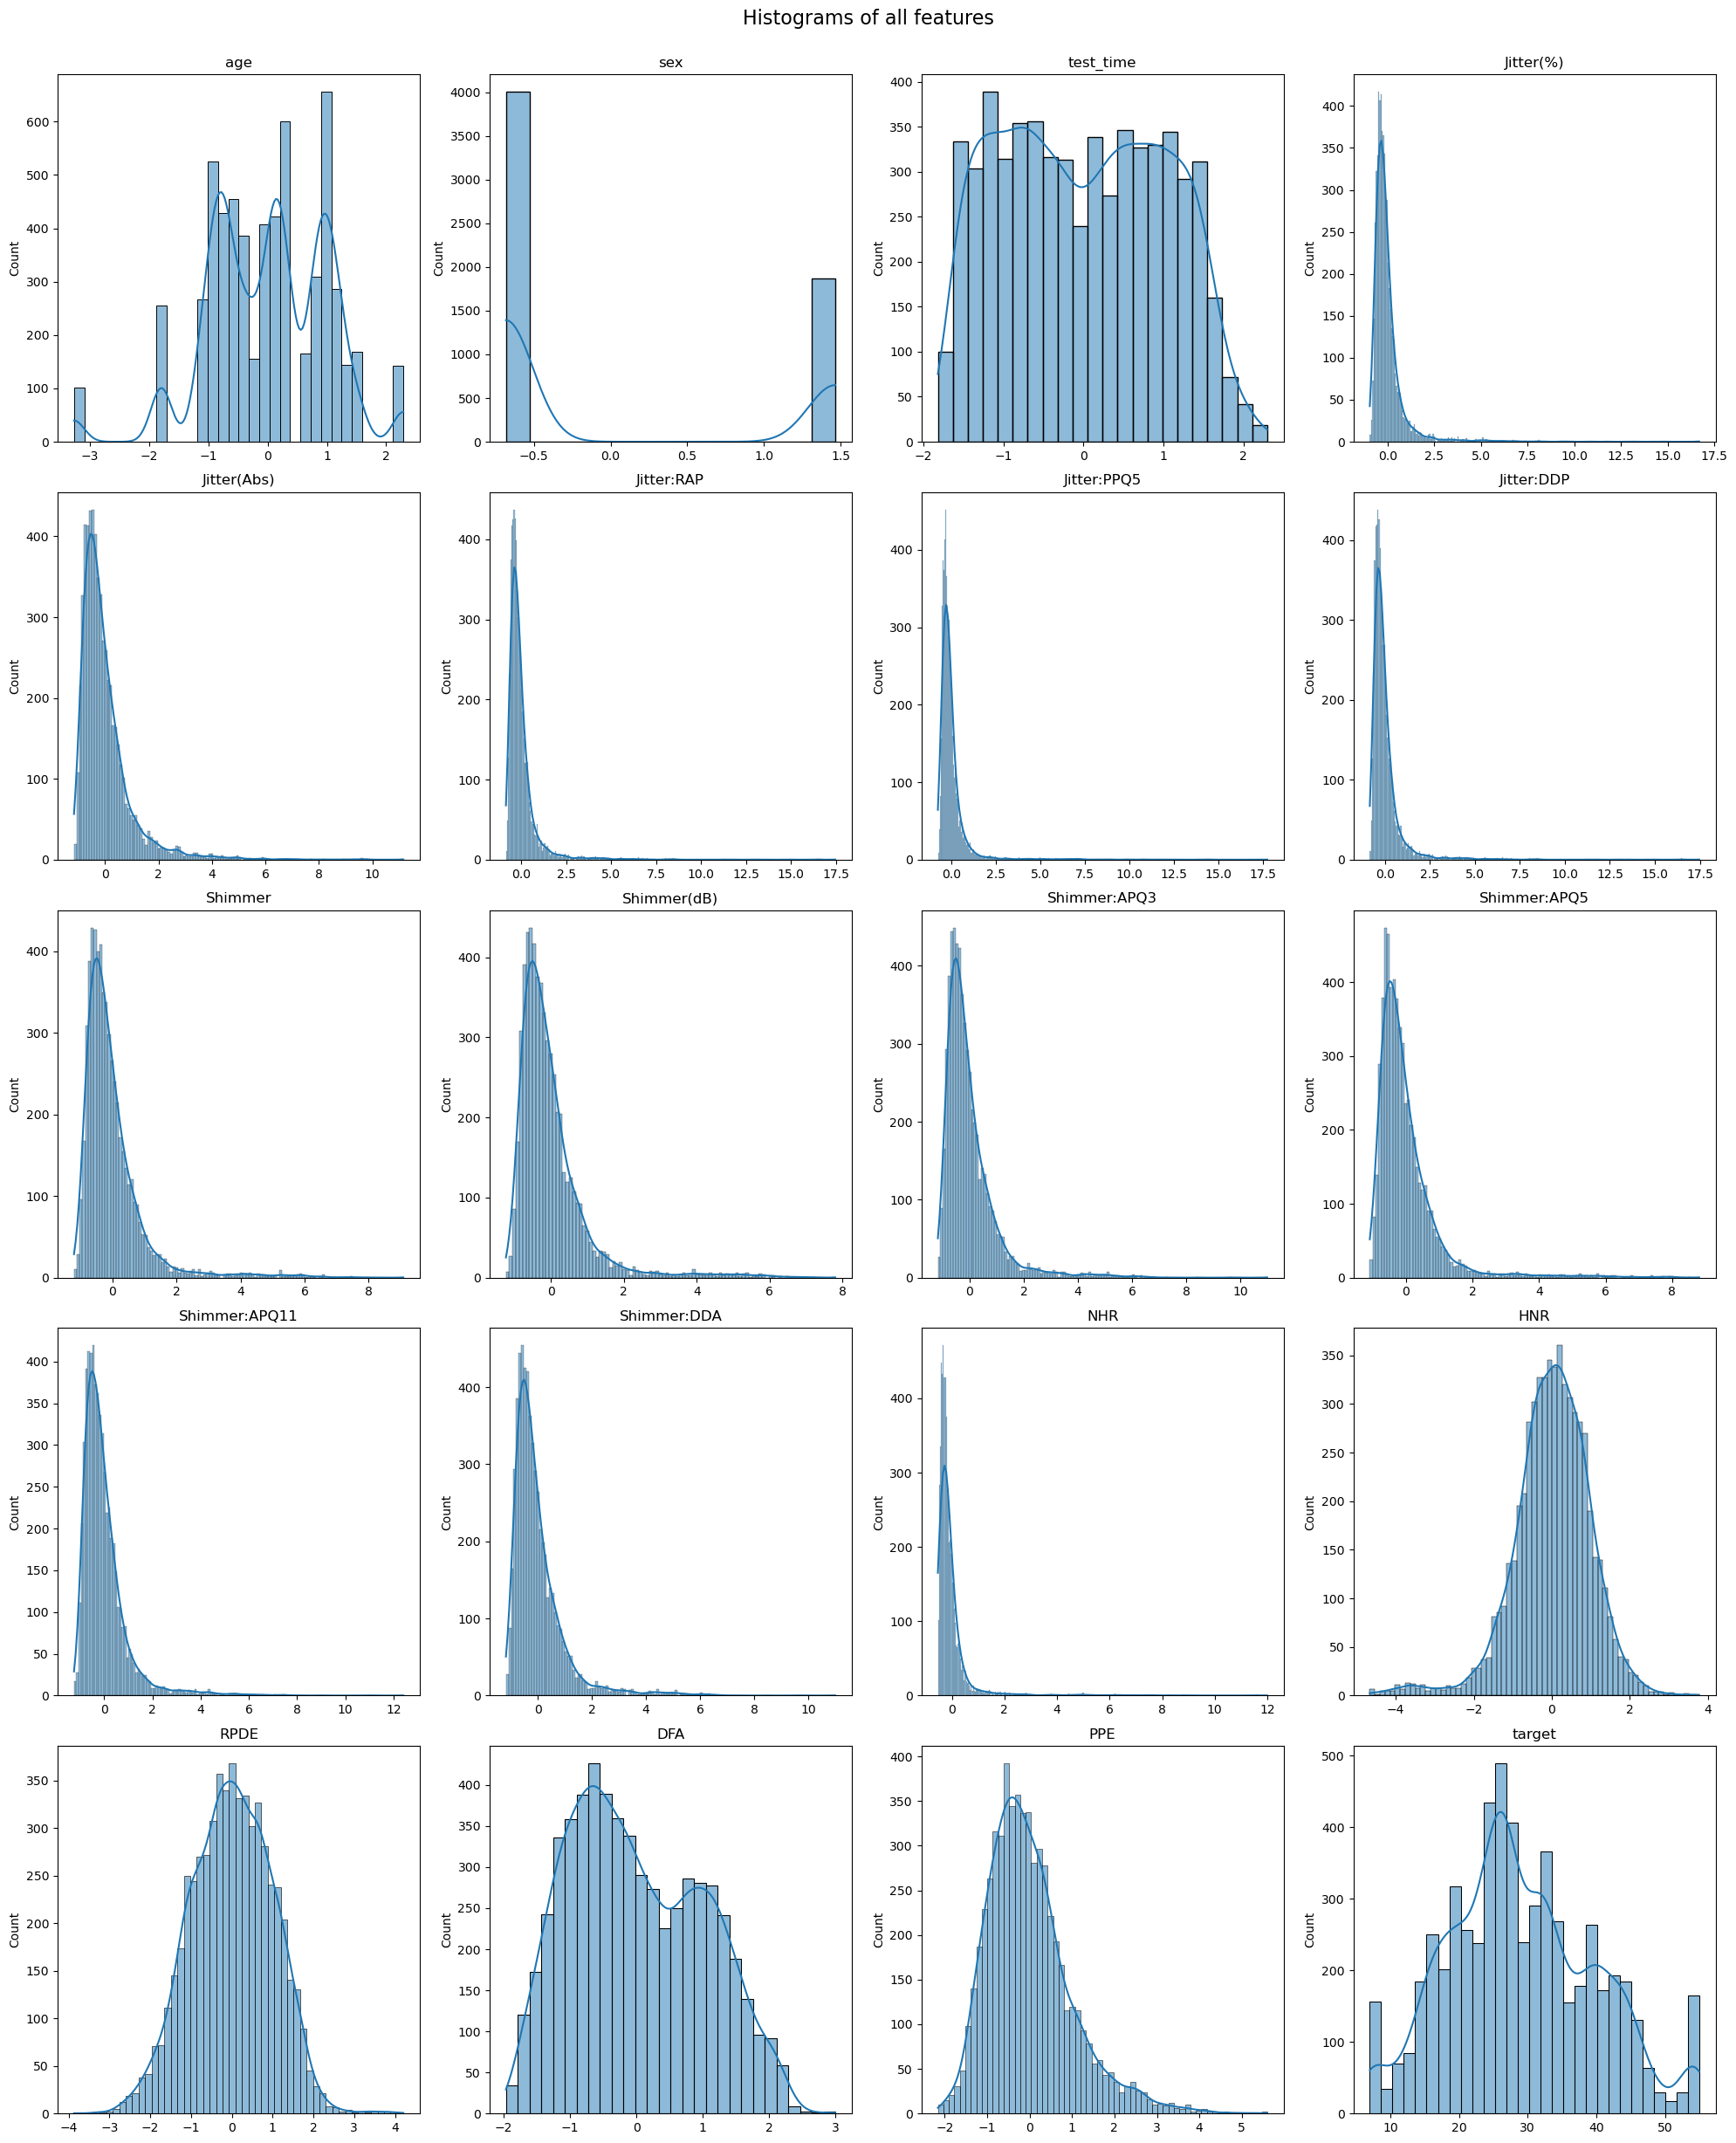

In [74]:
# Assuming park_data is already loaded

# Calculate min, max, and difference for each column
min_values = park_data.min()
max_values = park_data.max()
diff_values = max_values - min_values

# Create a DataFrame with min, max, and difference
summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Difference': diff_values
})

# Display the summary
print("Min, Max, and Difference values for each column:")
print(summary_df)

# Create histograms for all columns
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
fig.suptitle("Histograms of all features", fontsize=16)

for i, column in enumerate(park_data.columns):
    row = i // 4
    col = i % 4
    sns.histplot(park_data[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# 5) Model comparison
- Linear regression Model (LR)
- MLP Regressor with 2 hidden layers of 10 neurons each + no activation functions (MLP_NA)
- MLP Regressor with 2 hidden layers of 10 neurons each + ReLU activation functions (MLP_ReLU)



MLP random_state=0
Boxplot of Mean Absolute Error (MAE) for each model

### Data splitting

In [53]:
rand_st = list(range(1,11))

train_test_data = []
for rand in rand_st:
    inp_train_temp, inp_test_temp, tar_train_temp, tar_test_temp =\
    train_test_split(park_inp,park_tar,test_size=0.2,random_state=rand)
    train_test_data.append(
        [inp_train_temp, inp_test_temp, tar_train_temp, tar_test_temp])

Model Definition

In [54]:
# Linear Regression Model
linear_model = LinearRegression()

# MLP Regressor with 2 hidden layers, no activation
mlp_no_activation = MLPRegressor(hidden_layer_sizes=(10, 10),
                                 activation='identity',
                                 random_state=0)

# MLP Regressor with 2 hidden layers, ReLU activation
mlp_relu = MLPRegressor(hidden_layer_sizes=(10, 10),
                        activation='relu',
                        random_state=0)

# List of models
models = [linear_model, mlp_no_activation, mlp_relu]
model_names = ['Linear Regression', 'MLP (No Activation)', 'MLP (ReLU)']

In [55]:
def evaluate_model(model, X_train, y_train, X_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    return model.predict(X_test)

# Perform cross-validation and calculate MAE for each model
mae_scores = []

for model in models:
    mae_score_temp = []
    for run in range(10):
        y_pred = evaluate_model(model, train_test_data[run][0], train_test_data[run][2],
                       train_test_data[run][1])
        mae = mean_absolute_error(train_test_data[run][3], y_pred)
        mae_score_temp.append(mae)  # Negate because sklearn returns negative MAE
    mae_scores.append(mae_score_temp)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

Plot the results from the training.

Text(0, 0.5, 'MAE')

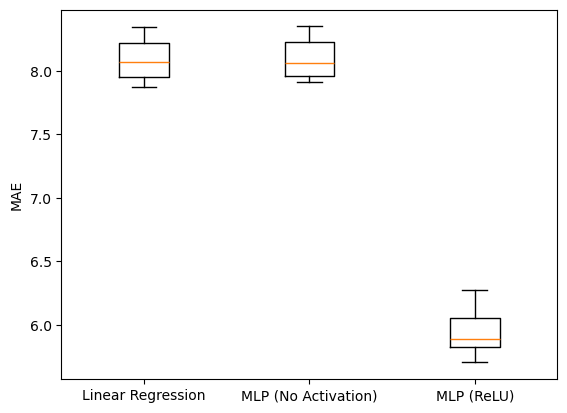

In [58]:
plt.boxplot(mae_scores, labels=model_names)
plt.ylabel("MAE")

# 6)
The results from the MLP_NA and the Linear Regression are very similar, this is because without an activation function the MLP produces only a Linear Regression.
From We can think of the Results that come up from the MLP Like


Z^{[1]} = W^{[1]}X^{[0]} + b^{[1]}

X^{[1]} = Z^{[1]}

Z^{[2]} = W^{[2]}X^{[1]} + b^{[2]}

X^{[2]} = Z^{[2]} = W^{[2]}W^{[1]}X^{[0]} + W^{[2]}b^{[1]} + b^{[2]}

Where the left half could also be represented as W and the right half a general constant 

# 7.
20-80 train-test split random_state = 0

Grid Search of hyperparameters from the model of MultiLayer Perceptron 2 hidden layers 10 neurons each
- (i)   L2 penalty    [0.001,0.01,0.1]
- (ii)  learning rate [0.001,0.01,0.1]
- (iii) batch size    [32,64,128]

# (legacy) fit and plot 

In [ ]:
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(park_inp,park_tar,test_size=0.2,random_state=rand)
#
# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
#
# # Define the model
# mlp = MLPRegressor(hidden_layer_sizes=(10, 10),
#                    max_iter=1000, random_state=0)
#
# # Define the parameter grid
# param_grid = {
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate_init': [0.001, 0.01, 0.1],
#     'batch_size': [32, 64, 128]
# }
#
# # Perform Grid Search
# grid_search = GridSearchCV(mlp, param_grid, cv=5,
#                            scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)
#
# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_
#
# print("Best parameters:", best_params)
# print("Best cross-validation MAE:", best_score)
#
# # Evaluate on the test set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_scaled)
# test_mae = mean_absolute_error(y_test, y_pred)
# print("Test set MAE:", test_mae)
#
# # Plot the results
# results = grid_search.cv_results_
# params = results['params']
# mean_scores = -results['mean_test_score']
#
# fig, ax = plt.subplots(figsize=(12, 8))
# scatter = ax.scatter([p['alpha'] for p in params],
#                      [p['learning_rate_init'] for p in params],
#                      c=mean_scores, s=[p['batch_size'] for p in params],
#                      cmap='viridis', alpha=0.7)
#
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('L2 penalty (alpha)')
# ax.set_ylabel('Learning rate')
# ax.set_title('Grid Search Results')
#
# cbar = plt.colorbar(scatter)
# cbar.set_label('Mean Absolute Error')
#
# # Add legend for batch size
# sizes = [32, 64, 128]
# labels = ['32', '64', '128']
# legend_elements = [plt.scatter([], [], s=size, c='gray', label=label)
#                    for size, label in zip(sizes, labels)]
# ax.legend(handles=legend_elements, title='Batch Size', loc='upper left')
#
# plt.tight_layout()
# plt.show()

# 7) 

In [71]:
# Split the data
X_train_notscaled, X_test_notscaled, y_train_notscaled, y_test_notscaled = train_test_split(park_inp,park_tar,test_size=0.2,random_state=rand)


# Define the model and parameter grid
mlp_notscaled = MLPRegressor(hidden_layer_sizes=(10, 10),
                   max_iter=1000, random_state=0)
param_grid_notscaled = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

# Perform Grid Search
grid_search_notscaled = GridSearchCV(mlp_notscaled, param_grid_notscaled, cv=5,
                           scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_notscaled.fit(X_train_notscaled, y_train_notscaled)

# Get results
results_notscaled = grid_search_notscaled.cv_results_
mae_scores_notscaled = -results_notscaled['mean_test_score']

# Reshape results for plotting
mae_matrix_notscaled = mae_scores_notscaled.reshape(3, 3, 3)

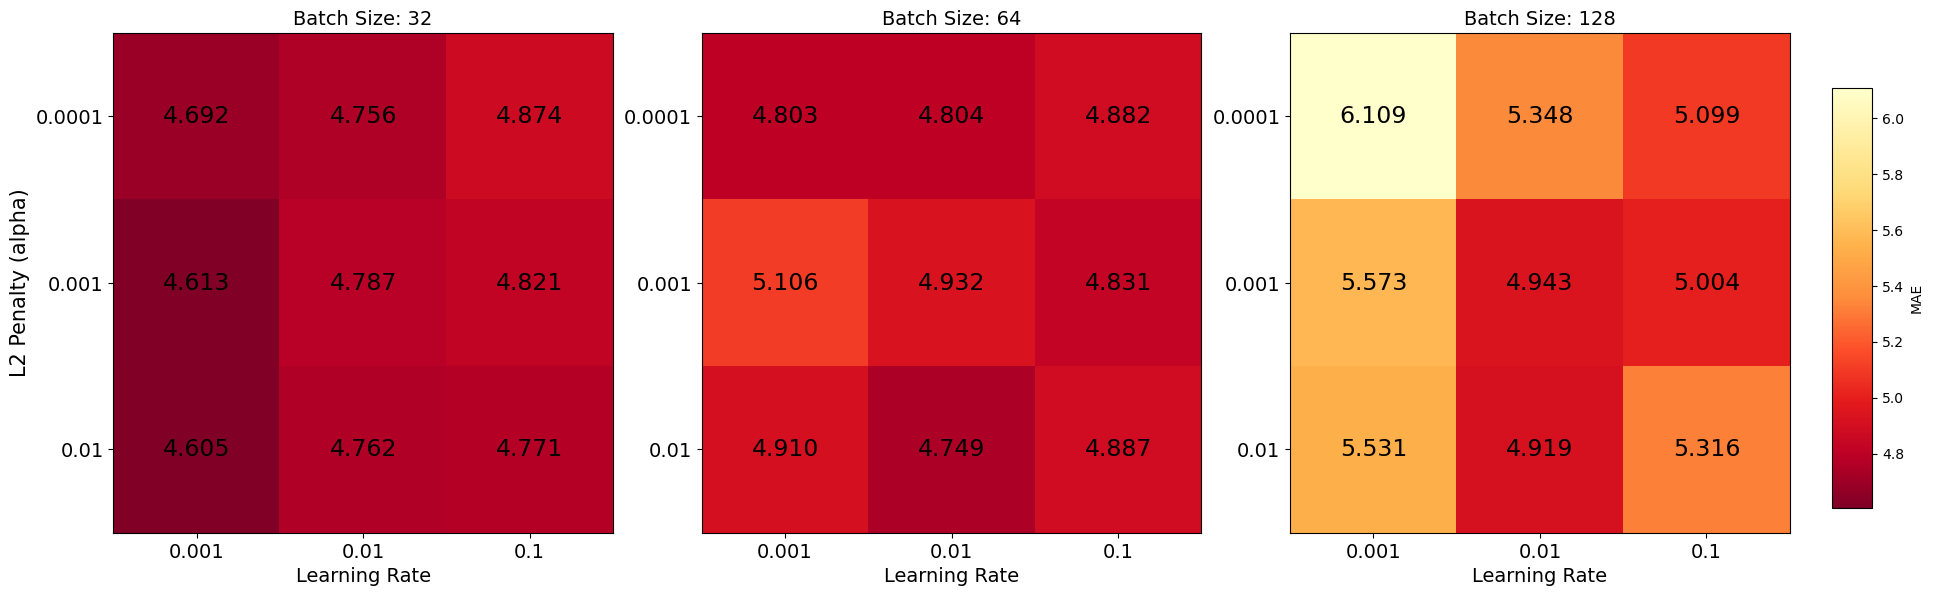

Best parameters: {'alpha': 0.01, 'batch_size': 32, 'learning_rate_init': 0.001}
Best cross-validation MAE: 4.60547151427975
Test set MAE: 4.469209552739158


In [82]:
# Plot the results
fig_notscaled, axes_notscaled = plt.subplots(1, 3, figsize=(20, 6))
batch_sizes_notscaled = [32, 64, 128]
# Find global min and max for consistent color scaling
value_min_notscaled = np.min(mae_matrix_notscaled)
value_max_notscaled = np.max(mae_matrix_notscaled)

for i, batch_size in enumerate(batch_sizes_notscaled):
    ax = axes_notscaled[i]
    im = ax.imshow(mae_matrix_notscaled[:, :, i], cmap='YlOrRd_r',
                   vmin=value_min_notscaled,vmax=value_max_notscaled)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels([0.001, 0.01, 0.1],fontsize=14)
    ax.set_yticklabels([0.0001, 0.001, 0.01],fontsize=14)
    ax.set_xlabel('Learning Rate',fontsize=14)
    if i == 0: ax.set_ylabel('L2 Penalty (alpha)',fontsize=15)
    ax.set_title(f'Batch Size: {batch_size}',fontsize=14)

    for j in range(3):
        for k in range(3):
            text = ax.text(k, j, f'{mae_matrix_notscaled[j, k, i]:.3f}',
                           ha="center", va="center", color="black",
                           fontsize=17)


plt.tight_layout()
fig_notscaled.subplots_adjust(right=0.9)

# Add a colorbar to the right of the subplots
cbar_ax = fig_notscaled.add_axes([0.92, 0.15, 0.02, 0.7])
fig_notscaled.colorbar(im, cax=cbar_ax, label='MAE')
plt.show()

# Get the best parameters and score
best_params_notscaled = grid_search_notscaled.best_params_
best_score_notscaled = -grid_search_notscaled.best_score_

print("Best parameters:", best_params_notscaled)
print("Best cross-validation MAE:", best_score_notscaled)

# Evaluate on the test set
best_model_notscaled = grid_search_notscaled.best_estimator_
y_pred_notscaled = best_model_notscaled.predict(X_test_notscaled)
test_mae_notscaled = mean_absolute_error(y_test_notscaled, y_pred_notscaled)
print("Test set MAE:", test_mae_notscaled)

# 7) Scaled version

In [67]:
# Split the data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(park_inp,park_tar,test_size=0.2,random_state=rand)

# Scale the features
scaler_scaled = StandardScaler()
X_train_scaled = scaler_scaled.fit_transform(X_train_scaled)
X_test_scaled = scaler_scaled.transform(X_test_scaled)

# Define the model and parameter grid
mlp_scaled = MLPRegressor(hidden_layer_sizes=(10, 10),
                   max_iter=1000, random_state=0)
param_grid_scaled = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

# Perform Grid Search
grid_search_scaled = GridSearchCV(mlp_scaled, param_grid_scaled, cv=5,
                           scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_scaled.fit(X_train_scaled, y_train_scaled)

# Get results
results_scaled = grid_search_scaled.cv_results_
mae_scores_scaled = -results_scaled['mean_test_score']

# Reshape results for plotting
mae_matrix_scaled = mae_scores_scaled.reshape(3, 3, 3)

Plot the results and print the outcomes

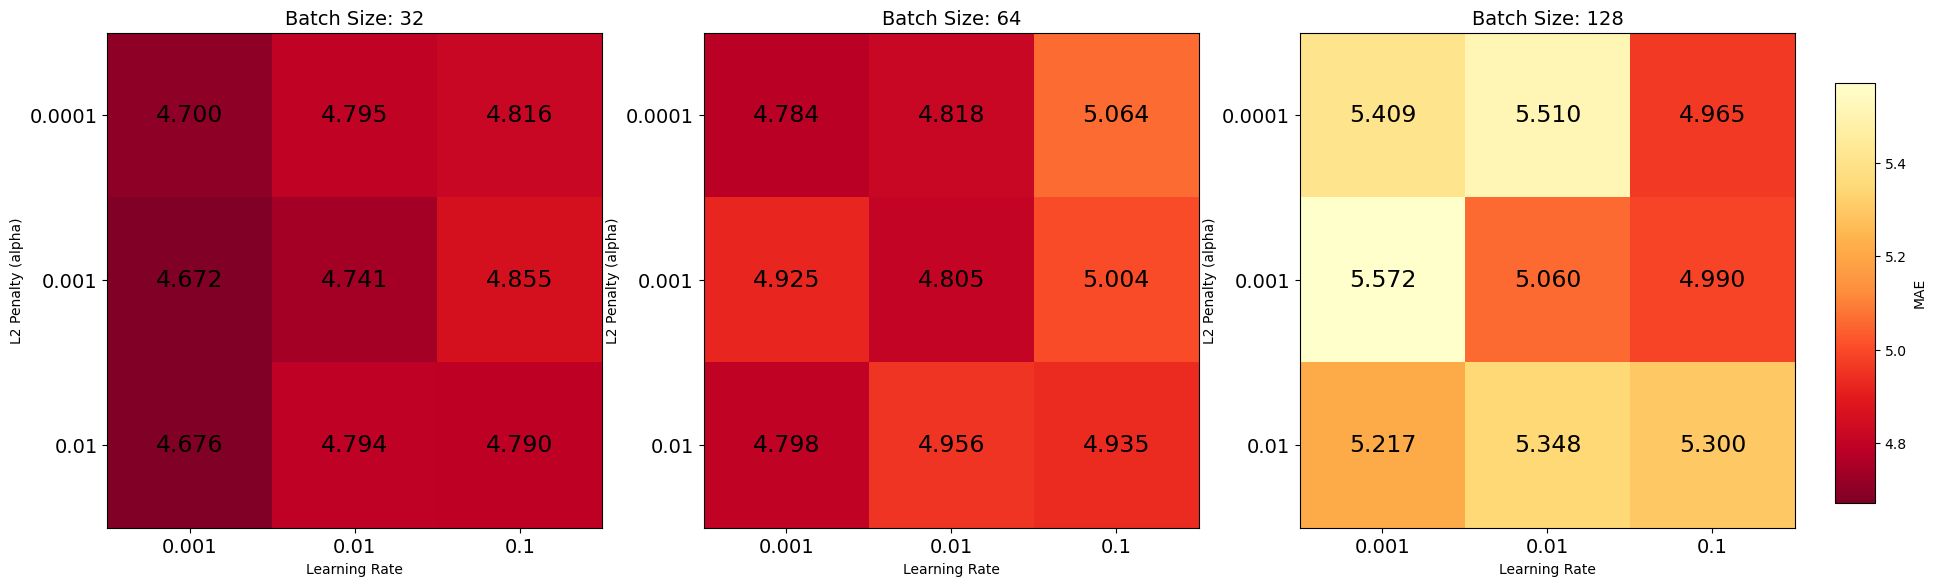

Best parameters: {'alpha': 0.001, 'batch_size': 32, 'learning_rate_init': 0.001}
Best cross-validation MAE: 4.671803824793015
Test set MAE: 4.337864759049698


In [78]:
# Plot the results
fig_scaled, axes_scaled = plt.subplots(1, 3, figsize=(20, 6))
batch_sizes_scaled = [32, 64, 128]
# Find global min and max for consistent color scaling
value_min_scaled = np.min(mae_matrix_scaled)
value_max_scaled = np.max(mae_matrix_scaled)

for i, batch_size in enumerate(batch_sizes_scaled):
    ax = axes_scaled[i]
    im = ax.imshow(mae_matrix_scaled[:, :, i], cmap='YlOrRd_r',
                   vmin=value_min_scaled,vmax=value_max_scaled)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels([0.001, 0.01, 0.1],fontsize=14)
    ax.set_yticklabels([0.0001, 0.001, 0.01],fontsize=14)
    ax.set_xlabel('Learning Rate',fontsize=14)
    if i == 0: ax.set_ylabel('L2 Penalty (alpha)',fontsize=15)
    ax.set_title(f'Batch Size: {batch_size}',fontsize=14)

    for j in range(3):
        for k in range(3):
            text = ax.text(k, j, f'{mae_matrix_scaled[j, k, i]:.3f}',
                           ha="center", va="center", color="black",
                           fontsize=17)


plt.tight_layout()
fig_scaled.subplots_adjust(right=0.9)

# Add a colorbar to the right of the subplots
cbar_ax = fig_scaled.add_axes([0.92, 0.15, 0.02, 0.7])
fig_scaled.colorbar(im, cax=cbar_ax, label='MAE')
plt.show()

# Get the best parameters and score
best_params_scaled = grid_search_scaled.best_params_
best_score_scaled = -grid_search_scaled.best_score_

print("Best parameters:", best_params_scaled)
print("Best cross-validation MAE:", best_score_scaled)

# Evaluate on the test set
best_model_scaled = grid_search_scaled.best_estimator_
y_pred_scaled = best_model_scaled.predict(X_test_scaled)
test_mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
print("Test set MAE:", test_mae_scaled)

# Test the statistical significance of scaling the inputs beforehand

Paired t-test results:
t-statistic: -0.12600930985460843
p-value: 0.9006939230521196

Mean difference (Not Scaled - Scaled): 0.004797465848799443
Percentage of cases where scaled version performs better: 44.44%


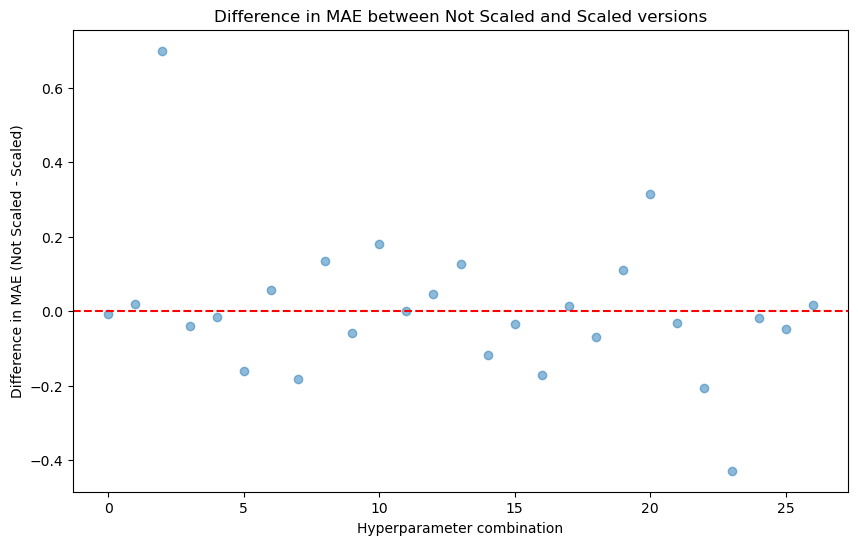

In [73]:
# Flatten the mae matrices
mae_scaled = mae_matrix_scaled.flatten()
mae_notscaled = mae_matrix_notscaled.flatten()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(mae_scaled, mae_notscaled)

print(f"Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Calculate mean difference
mean_difference = np.mean(mae_notscaled - mae_scaled)
print(f"\nMean difference (Not Scaled - Scaled): {mean_difference}")

# Calculate percentage of cases where scaled version performs better
scaled_better = np.sum(mae_scaled < mae_notscaled) / len(mae_scaled) * 100
print(f"Percentage of cases where scaled version performs better: {scaled_better:.2f}%")

# Visualize the differences
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mae_scaled)), mae_notscaled - mae_scaled, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Hyperparameter combination")
plt.ylabel("Difference in MAE (Not Scaled - Scaled)")
plt.title("Difference in MAE between Not Scaled and Scaled versions")
plt.show()